# Kaggle: Spaceship Titanic
##### Data: https://www.kaggle.com/competitions/spaceship-titanic/data

##### Difficulty: Easy
##### ***Happy Code!*** 
##### ***Víctor Núñez***

In [167]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from pycaret.classification import setup, compare_models
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve

from sklearn.tree import DecisionTreeClassifier

## 1) Data

In [2]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

In [3]:
target, PassengerId = train['Transported'], test['PassengerId']

train_0 = train.drop(['Transported','PassengerId','Name'],axis = 1)
test_0  = test.drop(['PassengerId', 'Name'], axis= 1)

data_0  = pd.concat([train_0, test_0], axis=0).reset_index(drop =  True)

In [4]:
data_0.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0


In [5]:
print(data_0.isna().sum())
print(data_0.shape)

HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
dtype: int64
(12970, 11)


# 2) Data Processing

In [6]:
data_0.select_dtypes(np.number).head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0


In [7]:
data_0.select_dtypes(object).head()

,HomePlanet,CryoSleep,Cabin,Destination,VIP
0,Europa,False,B/0/P,TRAPPIST-1e,False
1,Earth,False,F/0/S,TRAPPIST-1e,False
2,Europa,False,A/0/S,TRAPPIST-1e,True
3,Europa,False,A/0/S,TRAPPIST-1e,False
4,Earth,False,F/1/S,TRAPPIST-1e,False


In [8]:
data_0[['CryoSleep', 'VIP']] =  data_0[['CryoSleep', 'VIP']].astype(bool)

In [9]:
#Save
data_1 = data_0.copy()

####  2.1 - Filling Categoricals

In [10]:
data_1.describe(include='O')

,HomePlanet,Cabin,Destination
count,12682,12671,12696
unique,3,9825,3
top,Earth,G/734/S,TRAPPIST-1e
freq,6865,8,8871


In [11]:
cols_na = data_1.select_dtypes(object).loc[:,data_1.isna().any()==True].columns


# Impute using the column mode
for col in cols_na:
    data_1[col] = data_1[col].fillna(data_1[col].mode()[0])

In [12]:
data_2 =  data_1.copy()

#### 2.2 - Filling Numericals

In [13]:
cols_na =  data_2.select_dtypes(np.number).loc[:,data_2.isna().any() == True]

# Impute using mean value.
for col in cols_na:
    data_2[col] = data_2[col].fillna(data_2[col].mean().round(0))

In [14]:
data_3 = data_2.copy()

In [15]:
print(len(set(data_3.Cabin))) # So many different cabins!

9825


In [16]:
data_3['Deck'] = data_3['Cabin'].apply(lambda cabin: cabin.split('/')[0])
data_3['Num'] = data_3['Cabin'].apply(lambda cabin: cabin.split('/')[1])
data_3['Side'] = data_3['Cabin'].apply(lambda cabin: cabin.split('/')[2])

data_3.drop(['Cabin'], axis = 1, inplace =  True)

data_3['Num'] = data_3['Num'].astype(int) 

In [17]:
data_4 = data_3.copy()

In [18]:
data_4.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,1,S


#### 2.3 - Encoding Categoricals

In [19]:
enc = LabelEncoder()
for column in data_4.select_dtypes(object).columns:
    data_4[column] = enc.fit_transform(data_4[column])
    
for column in data_4.select_dtypes(bool).columns:
    data_4[column] = data_4[column].astype(int)
    
target = target.astype(int)

In [241]:
data_5 =  data_4.copy()

In [201]:

data_5.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,1,0,0
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,5,0,1
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,1
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,1
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,5,1,1


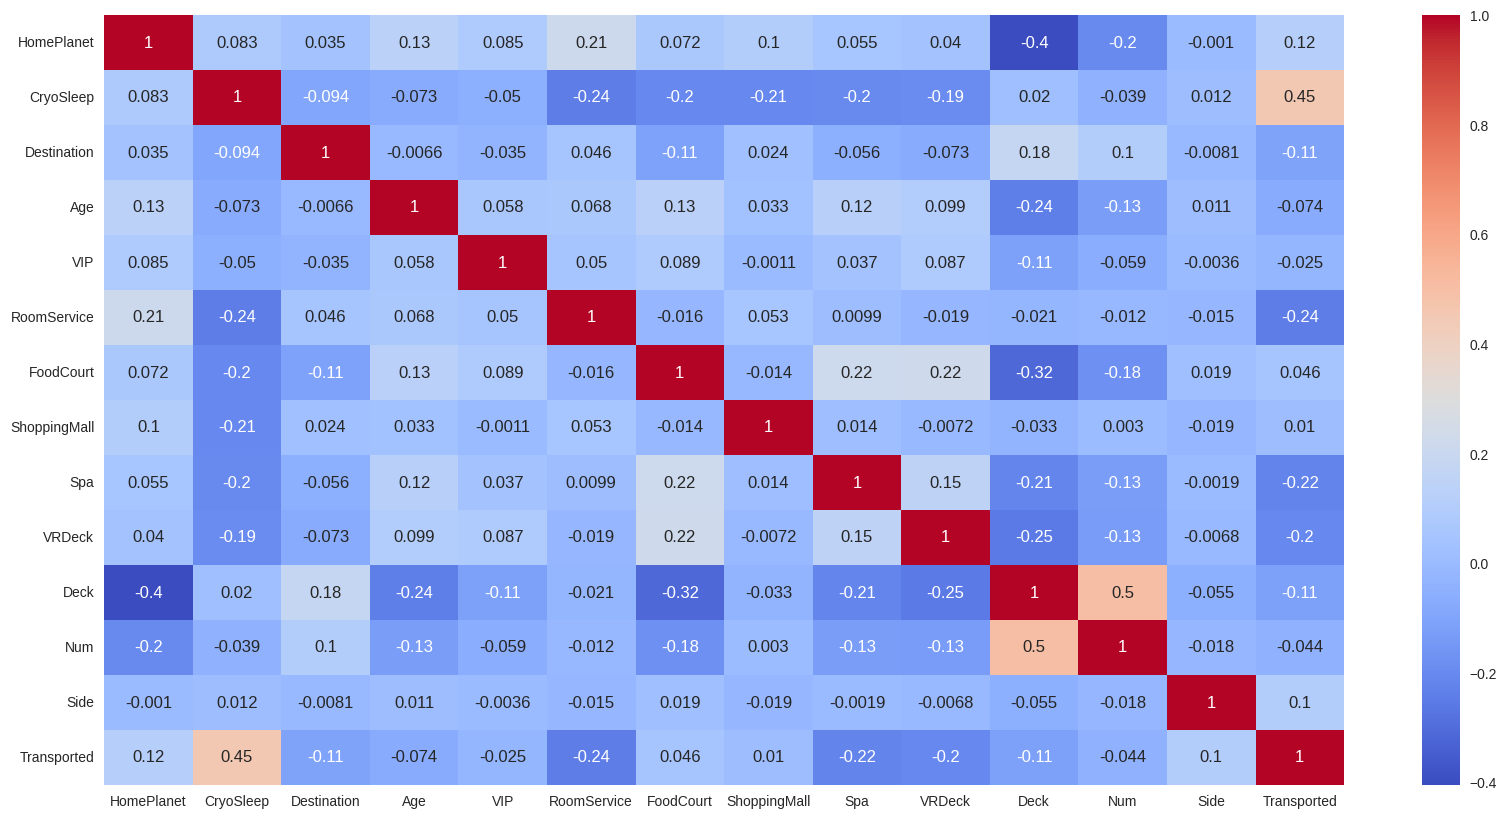

In [83]:
corr = pd.concat([(data_5.loc[:train_0.index.max(),:]),target],axis=1)

plt.figure(figsize=(20,10))
sns.heatmap(corr.corr(),annot=True, cmap="coolwarm")
plt.show()

#### 2.4 - Principal Component Analysis

In [253]:
pca = PCA(n_components=13)
matrix_data = data_5.values


transform_data = pca.fit_transform(matrix_data)

# Explained variance for each principal component
explained_variance = pca.explained_variance_ratio_

# Print the explained variance for each principal component
for i, variance in enumerate(explained_variance):
    print("Variance explained by Principal Component {}: {:.2f}%".format(i + 1, variance * 100))

Variance explained by Principal Component 1: 45.23%
Variance explained by Principal Component 2: 20.20%
Variance explained by Principal Component 3: 18.14%
Variance explained by Principal Component 4: 6.84%
Variance explained by Principal Component 5: 5.50%
Variance explained by Principal Component 6: 4.07%
Variance explained by Principal Component 7: 0.00%
Variance explained by Principal Component 8: 0.00%
Variance explained by Principal Component 9: 0.00%
Variance explained by Principal Component 10: 0.00%
Variance explained by Principal Component 11: 0.00%
Variance explained by Principal Component 12: 0.00%
Variance explained by Principal Component 13: 0.00%


In [254]:
pca = PCA(n_components=5)
new_matrix = pca.fit_transform(matrix_data)

#data_6 = pd.DataFrame(new_matrix, columns= ['feature_A','feature_B','feature_C','feature_D','feature_E','feature_F'])
data_6 = pd.DataFrame(new_matrix, columns= ['A','B','C','D','E'])

#### 2.4 - Final Split

In [255]:
train_final = (data_6.loc[:train_0.index.max(),:]).copy()
test_final  = (data_6.loc[train_0.index.max()+1:,:].reset_index(drop = True)).copy()

# 3) Model Selection

In [101]:
#setup(data = pd.concat([train_final, target], axis = 1), target = target)
#compare_models()

,Description,Value
0,Session id,6958
1,Target,Transported_y
2,Target type,Binary
3,Original data shape,"(8693, 10)"
4,Transformed data shape,"(8693, 10)"
5,Transformed train set shape,"(6085, 10)"
6,Transformed test set shape,"(2608, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.6470
nb,Naive Bayes,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1650
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1780
ridge,Ridge Classifier,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1050
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.1800
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1620
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.9970
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.8890
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.6400
knn,K Neighbors Classifier,0.7632,0.8209,0.8016,0.7470,0.7732,0.5261,0.5278,0.2330


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=6958, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### 3.1 - Hyper-Parameter Search

In [256]:
param_grid = {'criterion': ['gini','entropy'],
              'max_depth':[1,2,3,4,10,15,20],
              'max_features': [1,2,3,4,5,6]
              }

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring="accuracy", cv=5)
grid.fit(train_final, target)
print("Best score = %f, Best parameters = %s" % (1. - grid.best_score_, grid.best_params_))


Best score = 0.226041, Best parameters = {'criterion': 'gini', 'max_depth': 4, 'max_features': 5}


In [270]:
model_dt =  DecisionTreeClassifier(criterion= 'gini', max_depth= 4, max_features= 5, random_state = 42)
model_dt.fit(train_final, target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=42, splitter='best')

In [271]:
print('Acuraccy = {}'.format(model_dt.score(train_final,target)))

Acuraccy = 0.7814333371678361


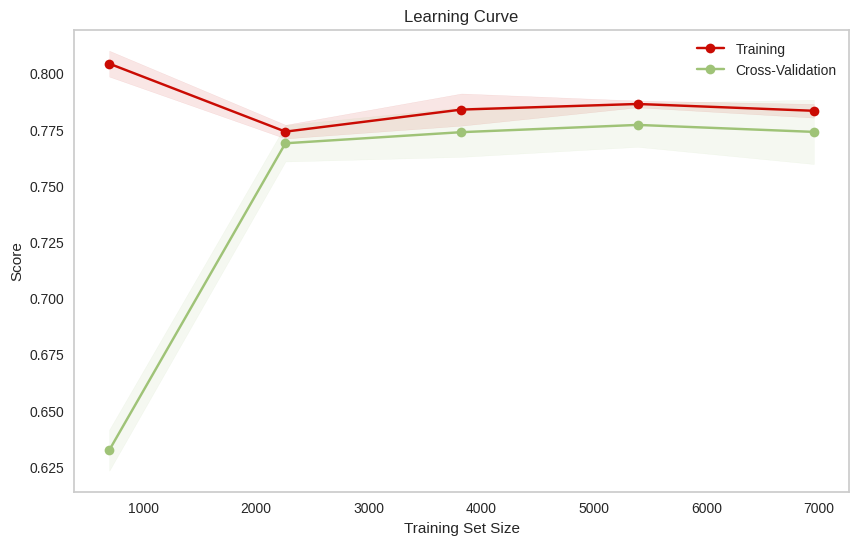

In [272]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation")
    
    plt.legend(loc="best")
    plt.show()

# Use the plot_learning_curve function passing your estimator (model), X (training data), and y (training labels)
plot_learning_curve(model_dt, train_final, target)


In [274]:
final_predictions = model_dt.predict(test_final)
final_predictions = final_predictions.astype(bool)
submission = pd.concat([PassengerId, pd.Series(final_predictions, name = 'Transported')], axis= 1)
submission.to_csv('./submission_predictions.csv',index=False, header= True)